# Importing Necessary libraries

In [320]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB

# Data Gathering

Data Understanding:

Examine the dataset description provided to understand the dataset's characteristics, including its size, label distribution, and features.
Review the "Label" and "WebURL" columns to understand the format of the data and the task at hand.

In [130]:
df = pd.read_csv("data/train.csv", low_memory=False, index_col=False)

In [131]:
df.head(5)

,phising_status,phising_urls,additional_urls
0,2,https://blog.sockpuppet.us/,NaN
1,2,https://blog.apiki.com/seguranca/,NaN
2,1,http://autoecole-lauriston.com/a/T0RVd056QXlNe...,NaN
3,1,http://chinpay.site/index.html?hgcFSE@E$Z*DFcG...,NaN
4,2,http://www.firstfivenebraska.org/blog/article/...,NaN


# Data Preprocessing:

Performing preprocessing steps such as data cleaning, removing duplicates, and handling missing values.
Tokenize the URLs into individual components (e.g., domain, path, query parameters) for further analysis.
Convert the textual data into numerical representations suitable for machine learning models.

In [132]:
# checking for missing values in dataset

df.isna().sum()

phising_status          0
phising_urls            0
additional_urls    639987
dtype: int64

In [133]:
# dropping "additional_urls" columns

df = df.drop(columns=["additional_urls"])

* As we can see no missing data found in columns phising_status, phising_urls and additional_urls column has 639987 missing values, which will not be an useful column for the analysis, so dropped the column.

In [134]:
df.head(5)

,phising_status,phising_urls
0,2,https://blog.sockpuppet.us/
1,2,https://blog.apiki.com/seguranca/
2,1,http://autoecole-lauriston.com/a/T0RVd056QXlNe...
3,1,http://chinpay.site/index.html?hgcFSE@E$Z*DFcG...
4,2,http://www.firstfivenebraska.org/blog/article/...


In [208]:
df['phising_status'].value_counts()

phising_status
2    319998
1    319995
Name: count, dtype: int64

In [135]:
df.size

1279986

In [136]:
# checking duplicate rows from the dataset to ensure data integrity
df.duplicated().sum()

0

No dulpicate data in the dataset

In [137]:
df

,phising_status,phising_urls
0,2,https://blog.sockpuppet.us/
1,2,https://blog.apiki.com/seguranca/
2,1,http://autoecole-lauriston.com/a/T0RVd056QXlNe...
3,1,http://chinpay.site/index.html?hgcFSE@E$Z*DFcG...
4,2,http://www.firstfivenebraska.org/blog/article/...
...,...,...
639988,1,https://palmettopublicsafetysolutions.com/wp-1...
639989,2,https://txt-holdings.com/csr/
639990,1,http://www.getbeyou.com/wp-admin/js/widgets/8n...
639991,2,https://www.doellerer.at/feine-kost/heringssch...


In [138]:
# removing leading/trailing whitespaces from the 'phising_urls' column

df1 = df.copy()

df1["phising_urls"] = df1['phising_urls'].str.strip()

In [139]:
df1.head(4)

,phising_status,phising_urls
0,2,https://blog.sockpuppet.us/
1,2,https://blog.apiki.com/seguranca/
2,1,http://autoecole-lauriston.com/a/T0RVd056QXlNe...
3,1,http://chinpay.site/index.html?hgcFSE@E$Z*DFcG...


In [140]:
# converting all textual data to lowercase to ensure consistency as mot of the urls contains upper letters

df2 = df1.copy()

df2["phising_urls"] = df2['phising_urls'].str.lower()

In [141]:
df2.head(3)


,phising_status,phising_urls
0,2,https://blog.sockpuppet.us/
1,2,https://blog.apiki.com/seguranca/
2,1,http://autoecole-lauriston.com/a/t0rvd056qxlne...


In [159]:
df2["phising_urls"][8]o

'http://j-hunterhunter.com/category/uncategorized/'

In [233]:
# tokenizing  URLs to split the URLs into individual components such as protocol, domain, path, query and fragment parameters.

df3 = df2.copy()

def tokenize_url(url):
    parsed_url = urlparse(url)
    return parsed_url


# tokenize urls
df3['parsed_url'] = df3['phising_urls'].apply(tokenize_url)

#extracting components from parsed_url
df3['protocol'] = df3['parsed_url'].apply(lambda x: x.scheme)
df3['domain'] = df3['parsed_url'].apply(lambda x: x.netloc)
df3['path'] = df3['parsed_url'].apply(lambda x: x.path)
df3['query_params'] = df3['parsed_url'].apply(lambda x: x.query)
df3['fragement'] = df3['parsed_url'].apply(lambda x: x.fragment)

In [234]:
df3.head(5)

,phising_status,phising_urls,parsed_url,protocol,domain,path,query_params,fragement
0,2,https://blog.sockpuppet.us/,"(https, blog.sockpuppet.us, /, , , )",https,blog.sockpuppet.us,/,,
1,2,https://blog.apiki.com/seguranca/,"(https, blog.apiki.com, /seguranca/, , , )",https,blog.apiki.com,/seguranca/,,
2,1,http://autoecole-lauriston.com/a/t0rvd056qxlne...,"(http, autoecole-lauriston.com, /a/t0rvd056qxl...",http,autoecole-lauriston.com,/a/t0rvd056qxlnelf6t1rnpq==/,,
3,1,http://chinpay.site/index.html?hgcfse@e$z*dfcg...,"(http, chinpay.site, /index.html, , hgcfse@e$z...",http,chinpay.site,/index.html,hgcfse@e$z*dfcgvhbinnikmojibhvgtfdrectfgvbh,
4,2,http://www.firstfivenebraska.org/blog/article/...,"(http, www.firstfivenebraska.org, /blog/articl...",http,www.firstfivenebraska.org,/blog/article/covid-19-daily-digest,,.xnvphyhkjiu


* After separating the protocol(scheme), domain(netloc), path, query_params(query), fragement form parsed_url, we can see most of the values in query_params and fragement is empty so need to fill these values.

# EDA(Exploratory Data Analysis)

In [235]:
# summary statistics for numerical features

numerical_summary = df3['phising_status'].describe()
print("Summary Statistics for Numerical Features 'phising_status' :\n", numerical_summary)

Summary Statistics for Numerical Features 'phising_status' :
 count    639993.000000
mean          1.500002
std           0.500000
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: phising_status, dtype: float64


In [236]:
# count of unique values and their frequencies for categorical features

categorical_features = ['protocol', 'domain', 'path', 'query_params', 'fragement']
categorical_summary = {}
for feature in categorical_features:
    unique_values_count = df3[feature].nunique()
    value_counts = df3[feature].value_counts()
    categorical_summary[feature] = {'unique_values_count': unique_values_count, 'value_counts': value_counts}

for feature , summary in categorical_summary.items():
    print(f"\nFeature: {feature}")
    print("Count of Unique Values:", summary['unique_values_count'])
    print('\nValue Counts:')
    print(summary['value_counts'])
    print("====================================================================")


Feature: protocol
Count of Unique Values: 22

Value Counts:
protocol
https        339145
http         300590
                161
mailto           36
ftp              19
feed             11
itpc              6
rsync             6
webcal            4
ts3server         2
hxxps             2
rtsp              1
htttp             1
ldap              1
safaris           1
ttp               1
thtp              1
file              1
appstream         1
pcast             1
ts3               1
irc               1
Name: count, dtype: int64

Feature: domain
Count of Unique Values: 416030

Value Counts:
domain
fepro.cs.buap.mx                      2283
platino.bg                            1514
onetalk.alibaba.com                   1442
69.167.151.209                        1404
bandcamp.com                          1254
                                      ... 
paksuetsin.net                           1
www.3qpharmacy.com                       1
radical-foregoing-myrtle.glitch.me       1
www.sie

* As we can see there most of the values in protocol, domain, path, query_params, fragement are blank so treating these values as a separate category(<UNK>) for 'unknown'. This approach allows the model to learn form instances where value is missing.

In [237]:
# replacing empty value with <UNK> for 'unknown'

features = ['protocol', 'domain', 'path', 'query_params', 'fragement']

for feature in features:
    df3[feature] = df3[feature].replace('', "<UNK>")


In [238]:
df3['protocol'].value_counts()

protocol
https        339145
http         300590
<UNK>           161
mailto           36
ftp              19
feed             11
itpc              6
rsync             6
webcal            4
ts3server         2
hxxps             2
rtsp              1
htttp             1
ldap              1
safaris           1
ttp               1
thtp              1
file              1
appstream         1
pcast             1
ts3               1
irc               1
Name: count, dtype: int64

In [241]:
# extracting the length of the URLs so we see if there is any relation between url length and phising_status 
# extracted the domain name to check any pattern between domain and phising_url

def get_url_length(url):
    return len(url)

df3['url_length'] = df3['phising_urls'].apply(get_url_length)

def get_domain_extension(domain):
    return domain.split('.')[-1]

df3['domain_extension'] = df3['domain'].apply(get_domain_extension)


In [242]:
df3

,phising_status,phising_urls,parsed_url,protocol,domain,path,query_params,fragement,url_length,domain_extension
0,2,https://blog.sockpuppet.us/,"(https, blog.sockpuppet.us, /, , , )",https,blog.sockpuppet.us,/,<UNK>,<UNK>,27,us
1,2,https://blog.apiki.com/seguranca/,"(https, blog.apiki.com, /seguranca/, , , )",https,blog.apiki.com,/seguranca/,<UNK>,<UNK>,33,com
2,1,http://autoecole-lauriston.com/a/t0rvd056qxlne...,"(http, autoecole-lauriston.com, /a/t0rvd056qxl...",http,autoecole-lauriston.com,/a/t0rvd056qxlnelf6t1rnpq==/,<UNK>,<UNK>,58,com
3,1,http://chinpay.site/index.html?hgcfse@e$z*dfcg...,"(http, chinpay.site, /index.html, , hgcfse@e$z...",http,chinpay.site,/index.html,hgcfse@e$z*dfcgvhbinnikmojibhvgtfdrectfgvbh,<UNK>,74,site
4,2,http://www.firstfivenebraska.org/blog/article/...,"(http, www.firstfivenebraska.org, /blog/articl...",http,www.firstfivenebraska.org,/blog/article/covid-19-daily-digest,<UNK>,.xnvphyhkjiu,80,org
...,...,...,...,...,...,...,...,...,...,...
639988,1,https://palmettopublicsafetysolutions.com/wp-1...,"(https, palmettopublicsafetysolutions.com, /wp...",https,palmettopublicsafetysolutions.com,/wp-1home/home.php,public/enroll/identifyuser-aspx-lob=rbglogon=m...,<UNK>,162,com
639989,2,https://txt-holdings.com/csr/,"(https, txt-holdings.com, /csr/, , , )",https,txt-holdings.com,/csr/,<UNK>,<UNK>,29,com
639990,1,http://www.getbeyou.com/wp-admin/js/widgets/8n...,"(http, www.getbeyou.com, /wp-admin/js/widgets/...",http,www.getbeyou.com,/wp-admin/js/widgets/8nsq9ma65w54ze/profile/ac...,id=c7668510137d25018da33289cb213a17country=gr/...,<UNK>,142,com
639991,2,https://www.doellerer.at/feine-kost/heringssch...,"(https, www.doellerer.at, /feine-kost/heringss...",https,www.doellerer.at,/feine-kost/heringsschmaus,<UNK>,<UNK>,50,at


## Data Visualization

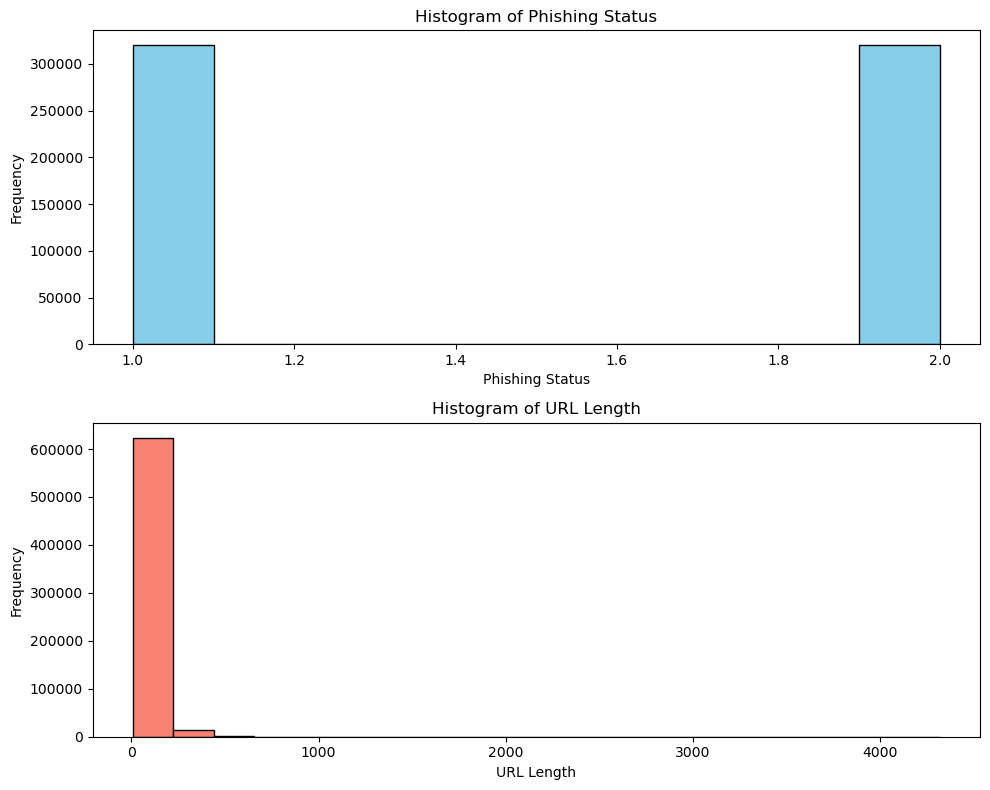

In [250]:
# histogram for the numerical features 'phising_status' and 'url_length'

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].hist(df3['phising_status'], bins=10, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Phishing Status')
axs[0].set_xlabel('Phishing Status')
axs[0].set_ylabel('Frequency')

axs[1].hist(df3['url_length'], bins=20, color='salmon', edgecolor='black')
axs[1].set_title('Histogram of URL Length')
axs[1].set_xlabel('URL Length')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
                        


1) Phishing Status:
    * The histogram shows that the frequency of phishing (status 1) and legitimate (status 2) URLs is approximately the same, both around 300,000.
    * This suggests that the dataset is balanced in terms of phishing and legitimate URLs.
2) URL Length:
    * The histogram reveals that most URLs have a length in the range of 0 to 500 characters, with a frequency of over 600,000.
    * There are fewer URLs with lengths exceeding 500 characters, indicating that the majority of URLs in the dataset are relatively short.

C:\Users\deepak.thakur\AppData\Local\Temp\ipykernel_3420\937511299.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(value_counts.index,rotation=90)
C:\Users\deepak.thakur\AppData\Local\Temp\ipykernel_3420\937511299.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(value_counts.index,rotation=90)


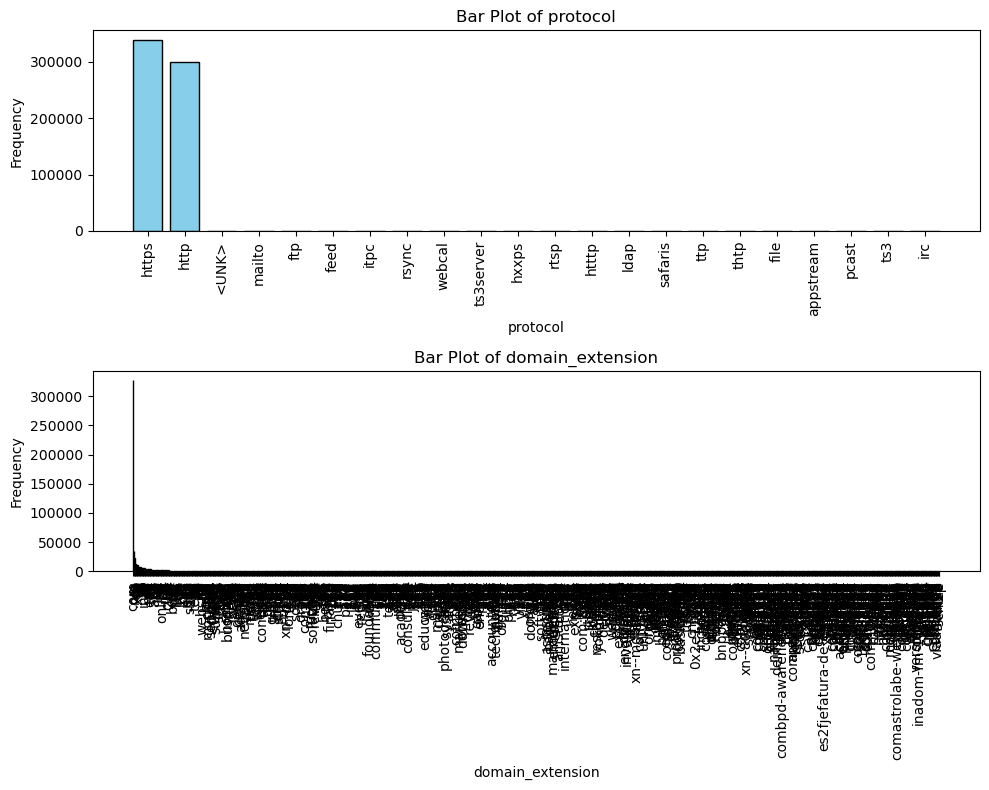

In [271]:
# bar plot for categorical features 'protocol' and 'domain_extension'

categorical_features = ['protocol', 'domain_extension']

fig, ax = plt.subplots(len(categorical_features), 1, figsize=(10,8))
for i, feature in enumerate(categorical_features):
    value_counts = df3[feature].value_counts()
    ax[i].bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
    ax[i].set_title(f'Bar Plot of {feature}')
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xticklabels(value_counts.index,rotation=90)

plt.tight_layout()
plt.show()

* Both "https" and "http" protocols have a frequency of around 300,000, indicating a balanced distribution between the two protocols.
* The ".com" domain extension has the highest frequency, exceeding 300,000, suggesting that it is the most common domain extension in the dataset.

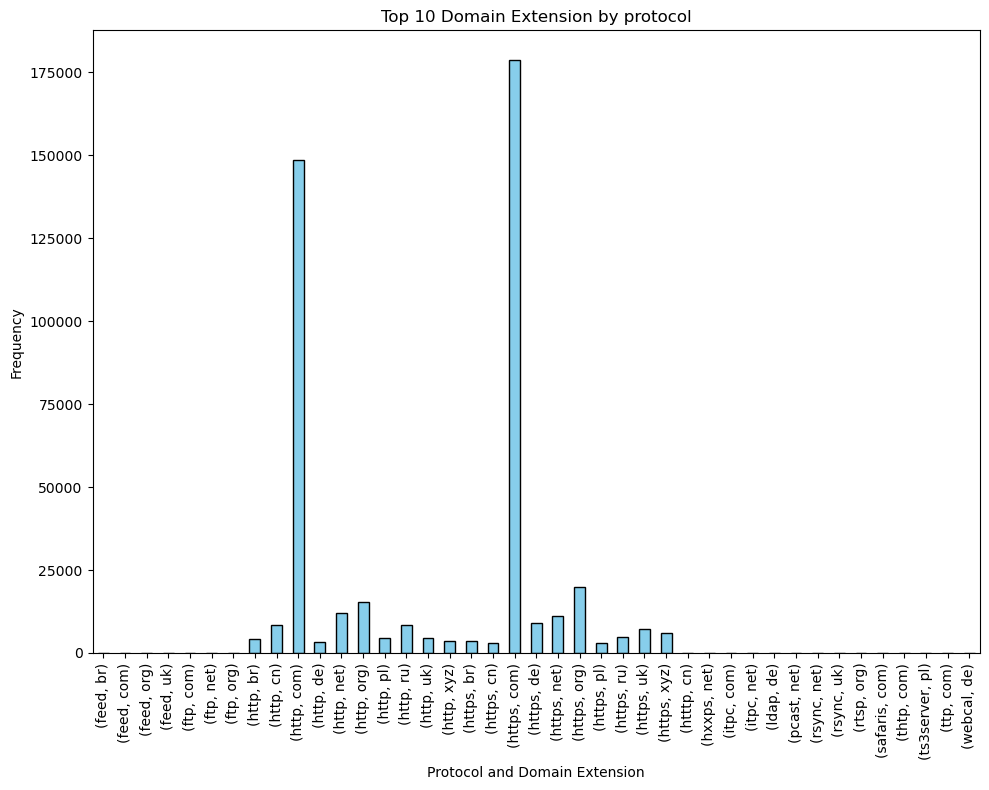

In [266]:
# top 10 domain extension along with the protocol

top_10_domain_extension = df3['domain_extension'].value_counts().nlargest(10)
top_10_domain_extension_with_protocol = df3[df3['domain_extension'].isin(top_10_domain_extension.index)][['protocol', 'domain_extension']]
value_counts = top_10_domain_extension_with_protocol.groupby(['protocol', 'domain_extension']).size()

plt.figure(figsize=(10,8))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Domain Extension by protocol')
plt.xlabel('Protocol and Domain Extension')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


* The domain extension ".com" is the most common among both "https" and "http" protocols, with a frequency of 175,000 and 150,000, respectively.
* The combination of "https" protocol with ".org" domain extension has a frequency of 25,000, indicating a relatively lower occurrence compared to ".com" extensions.
* The frequency distribution suggests that ".com" domain extensions are widely used across both "https" and "http" protocols, while other extensions like ".org" are less prevalent.

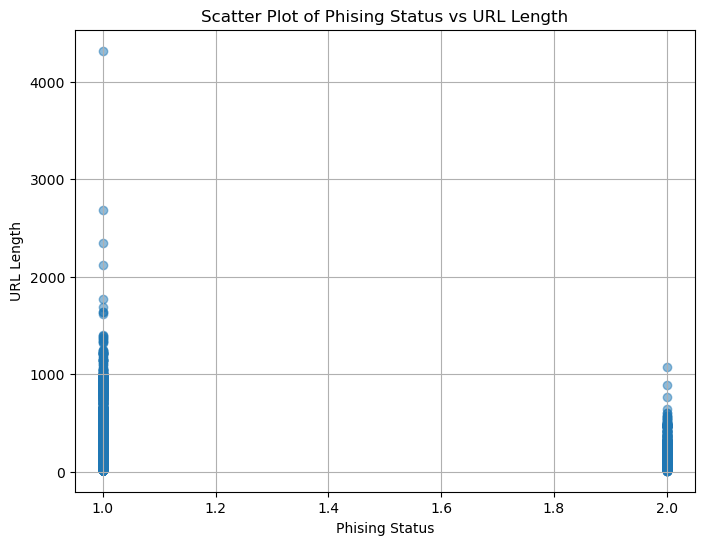

In [277]:
# scatter plot relation between phising_status and url_length

plt.figure(figsize=(8,6))
plt.scatter(df3['phising_status'], df3['url_length'], alpha=0.5)
plt.title('Scatter Plot of Phising Status vs URL Length')
plt.xlabel('Phising Status')
plt.ylabel('URL Length')
plt.grid(True)
plt.show()


* URLs classified as phishing (status 1) tend to have a wider range of URL lengths, with some URLs exceeding 1000 characters.
* Legitimate URLs (status 2) generally have shorter lengths, with most falling below 800 characters.
* There are instances of phishing URLs (status 1) with extremely long lengths, surpassing 1500 characters.

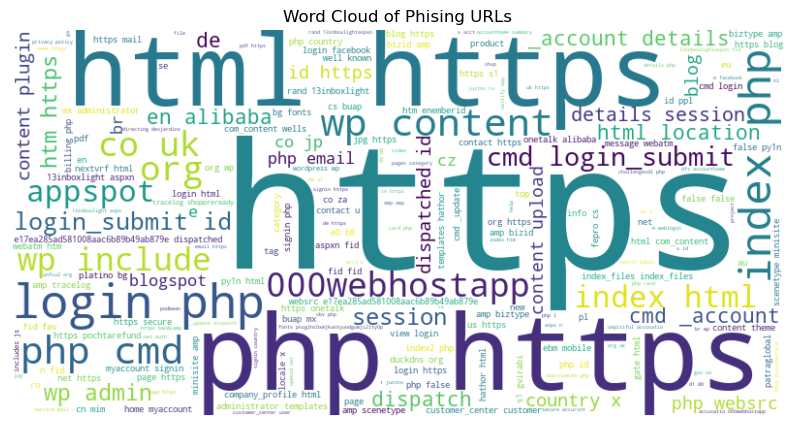

In [294]:
text = ' '.join(df3['phising_urls'])

wordclound = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phising URLs')
plt.show()


In [296]:
df3.head(5)

,phising_status,phising_urls,parsed_url,protocol,domain,path,query_params,fragement,url_length,domain_extension
0,2,https://blog.sockpuppet.us/,"(https, blog.sockpuppet.us, /, , , )",https,blog.sockpuppet.us,/,<UNK>,<UNK>,27,us
1,2,https://blog.apiki.com/seguranca/,"(https, blog.apiki.com, /seguranca/, , , )",https,blog.apiki.com,/seguranca/,<UNK>,<UNK>,33,com
2,1,http://autoecole-lauriston.com/a/t0rvd056qxlne...,"(http, autoecole-lauriston.com, /a/t0rvd056qxl...",http,autoecole-lauriston.com,/a/t0rvd056qxlnelf6t1rnpq==/,<UNK>,<UNK>,58,com
3,1,http://chinpay.site/index.html?hgcfse@e$z*dfcg...,"(http, chinpay.site, /index.html, , hgcfse@e$z...",http,chinpay.site,/index.html,hgcfse@e$z*dfcgvhbinnikmojibhvgtfdrectfgvbh,<UNK>,74,site
4,2,http://www.firstfivenebraska.org/blog/article/...,"(http, www.firstfivenebraska.org, /blog/articl...",http,www.firstfivenebraska.org,/blog/article/covid-19-daily-digest,<UNK>,.xnvphyhkjiu,80,org


In [300]:
df3

,phising_status,phising_urls,parsed_url,protocol,domain,path,query_params,fragement,url_length,domain_extension
0,2,https://blog.sockpuppet.us/,"(https, blog.sockpuppet.us, /, , , )",https,blog.sockpuppet.us,/,<UNK>,<UNK>,27,us
1,2,https://blog.apiki.com/seguranca/,"(https, blog.apiki.com, /seguranca/, , , )",https,blog.apiki.com,/seguranca/,<UNK>,<UNK>,33,com
2,1,http://autoecole-lauriston.com/a/t0rvd056qxlne...,"(http, autoecole-lauriston.com, /a/t0rvd056qxl...",http,autoecole-lauriston.com,/a/t0rvd056qxlnelf6t1rnpq==/,<UNK>,<UNK>,58,com
3,1,http://chinpay.site/index.html?hgcfse@e$z*dfcg...,"(http, chinpay.site, /index.html, , hgcfse@e$z...",http,chinpay.site,/index.html,hgcfse@e$z*dfcgvhbinnikmojibhvgtfdrectfgvbh,<UNK>,74,site
4,2,http://www.firstfivenebraska.org/blog/article/...,"(http, www.firstfivenebraska.org, /blog/articl...",http,www.firstfivenebraska.org,/blog/article/covid-19-daily-digest,<UNK>,.xnvphyhkjiu,80,org
...,...,...,...,...,...,...,...,...,...,...
639988,1,https://palmettopublicsafetysolutions.com/wp-1...,"(https, palmettopublicsafetysolutions.com, /wp...",https,palmettopublicsafetysolutions.com,/wp-1home/home.php,public/enroll/identifyuser-aspx-lob=rbglogon=m...,<UNK>,162,com
639989,2,https://txt-holdings.com/csr/,"(https, txt-holdings.com, /csr/, , , )",https,txt-holdings.com,/csr/,<UNK>,<UNK>,29,com
639990,1,http://www.getbeyou.com/wp-admin/js/widgets/8n...,"(http, www.getbeyou.com, /wp-admin/js/widgets/...",http,www.getbeyou.com,/wp-admin/js/widgets/8nsq9ma65w54ze/profile/ac...,id=c7668510137d25018da33289cb213a17country=gr/...,<UNK>,142,com
639991,2,https://www.doellerer.at/feine-kost/heringssch...,"(https, www.doellerer.at, /feine-kost/heringss...",https,www.doellerer.at,/feine-kost/heringsschmaus,<UNK>,<UNK>,50,at


In [311]:
df3.iloc[0,:]

phising_status                                         2
phising_urls                 https://blog.sockpuppet.us/
parsed_url          (https, blog.sockpuppet.us, /, , , )
protocol                                           https
domain                                blog.sockpuppet.us
path                                                   /
query_params                                       <UNK>
fragement                                          <UNK>
url_length                                            27
domain_extension                                      us
Name: 0, dtype: object

In [340]:
df3.iloc[:,3:]

,protocol,domain,path,query_params,fragement,url_length,domain_extension
0,https,blog.sockpuppet.us,/,<UNK>,<UNK>,27,us
1,https,blog.apiki.com,/seguranca/,<UNK>,<UNK>,33,com
2,http,autoecole-lauriston.com,/a/t0rvd056qxlnelf6t1rnpq==/,<UNK>,<UNK>,58,com
3,http,chinpay.site,/index.html,hgcfse@e$z*dfcgvhbinnikmojibhvgtfdrectfgvbh,<UNK>,74,site
4,http,www.firstfivenebraska.org,/blog/article/covid-19-daily-digest,<UNK>,.xnvphyhkjiu,80,org
...,...,...,...,...,...,...,...
639988,https,palmettopublicsafetysolutions.com,/wp-1home/home.php,public/enroll/identifyuser-aspx-lob=rbglogon=m...,<UNK>,162,com
639989,https,txt-holdings.com,/csr/,<UNK>,<UNK>,29,com
639990,http,www.getbeyou.com,/wp-admin/js/widgets/8nsq9ma65w54ze/profile/ac...,id=c7668510137d25018da33289cb213a17country=gr/...,<UNK>,142,com
639991,https,www.doellerer.at,/feine-kost/heringsschmaus,<UNK>,<UNK>,50,at


# Model Building

In [384]:
X_text = df3[['protocol','domain', 'path', 'query_params', 'fragement', 'url_length', 'domain_extension']].astype(str)
X_text['text'] = X_text.apply(lambda row: ' '.join(row), axis=1)


In [385]:
X = X_text['text'].tolist()
Y = df['phising_status']

In [386]:
len(X)

639993

In [387]:
Y.shape

(639993,)

In [391]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

In [392]:
# splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.1, stratify=Y, random_state=42)

In [396]:
X_train.shape


(575993, 716522)

In [394]:
model = GaussianNB()
model.fit(X_train, y_train)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [390]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf',GaussianNB())])
model = pipe.fit(X_train, y_train)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.